In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as si
import warnings
import pynwb
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
brain_observatory_cache_manifest_file = 'boc/manifest.json'

# Quick Start

In [3]:
ophys_experiment_id = 580124131
boc = BrainObservatoryCache(manifest_file=brain_observatory_cache_manifest_file)
exp = boc.get_ophys_experiment_data(ophys_experiment_id)
legacy_map = pynwb.legacy.get_type_map()
io2 = pynwb.NWBHDF5IO(exp.nwb_file, extensions=legacy_map, mode='r')
with warnings.catch_warnings(record=True) as w:
    nwb_data = io2.read() 

# Using allensdk to access the Brain Observatory:
This notebook documents the use of  <a href=http://pynwb.readthedocs.io/en/latest/>pynwb</a>. The <a href=http://alleninstitute.github.io/AllenSDK/>allensdk</a> provides functionality to download and cache Neurodata Without Borders (nwb) files associated with experiments from the <a http://observatory.brain-map.org/visualcoding/>Brain Observatory</a>.

To begin, we use the allensdk to download the Brain Observatory experiment containers.  The experiment container describes a set of experiments performed with the same targeted area, imaging depth, and Cre line.  


if you find an experiment in the Brain Observatory using the interactive website: <a http://observatory.brain-map.org/visualcoding/search/overview>http://observatory.brain-map.org/visualcoding/search/overview</a>, you can just set the container id manually.  For example, container `580051757` is summarized at a glance <a http://observatory.brain-map.org/visualcoding/search/experiment?id=580051757>here</a>; to get data for this container we would input the container id directly:

In [4]:
boc = BrainObservatoryCache(manifest_file=brain_observatory_cache_manifest_file)
ophys_experiment_list = boc.get_ophys_experiments(experiment_container_ids=[569811199])
pd.DataFrame(ophys_experiment_list)

,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,id,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
0,159,Nr5a1-Cre,279430,569811199,False,570014520,300,Ai93(TITL-GCaMP6f),three_session_B,Nr5a1-Cre;Camk2a-tTA;Ai93-279430,VISp
1,157,Nr5a1-Cre,279430,569811199,True,569811201,300,Ai93(TITL-GCaMP6f),three_session_A,Nr5a1-Cre;Camk2a-tTA;Ai93-279430,VISp
2,160,Nr5a1-Cre,279430,569811199,True,570087662,300,Ai93(TITL-GCaMP6f),three_session_C2,Nr5a1-Cre;Camk2a-tTA;Ai93-279430,VISp


Alternatively, The `BrainObservatoryCache` has a number of functions for figuring out what experiment containers are available. After you are done with the tutorial, uncomment out this code to explore some other experiment containers:



In [5]:
# boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
# visp_experiment_containers = boc.get_experiment_containers(targeted_structures=['VISp'])
# visp_experiment_container = visp_experiment_containers[0]
# visp_experiment_container_id = visp_experiment_container['id']
# ophys_experiment_list = boc.get_ophys_experiments(experiment_container_ids=[visp_experiment_container_id])
# pd.DataFrame(ophys_experiment_list)

Each of these three "ophys experiments" corresponds to a single 2-photon microscopy recording session. In each container, the particular visual stimulus that was presented is indicated by the `session_type`.  Each `session_type` contains several diffferent stimulus sets; for more information, take a look at the <a http://help.brain-map.org/display/observatory/Data+-+Visual+Coding>whitepaper</a>.

For each of these three ophys experiments lets use pynwb to load the data from the nwb files in the `BrainObservatoryCache` (files that are from a legacy version of nwb (i.e nwb_version < 1.0.6) might cause some warnings, but dont worry). If this is the first time through this notebook this might take a minute to download these files, and will require approximately 1Gb of total disk space for the three nwb files: 

In [6]:
session_filename_dict = {}
for ophys_experiment in ophys_experiment_list:
    session_type = ophys_experiment['session_type']
    ophys_experiment_id = ophys_experiment['id']
    
    # Get the data file:
    print 'Getting nwb file for ophys experiment: %s' % ophys_experiment_id
    nwb_file_name = boc.get_ophys_experiment_data(ophys_experiment_id).nwb_file
    session_filename_dict[session_type] = nwb_file_name
    print '   nwb data stored in: %s' % nwb_file_name

2017-11-06 10:47:48,947 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/570060033


Getting nwb file for ophys experiment: 570014520


2017-11-06 10:48:07,695 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569953245


   nwb data stored in: /home/nicholasc/projects/pynwb/docs/notebooks/boc/ophys_experiment_data/570014520.nwb
Getting nwb file for ophys experiment: 569811201


2017-11-06 10:48:36,603 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/570236238


   nwb data stored in: /home/nicholasc/projects/pynwb/docs/notebooks/boc/ophys_experiment_data/569811201.nwb
Getting nwb file for ophys experiment: 570087662
   nwb data stored in: /home/nicholasc/projects/pynwb/docs/notebooks/boc/ophys_experiment_data/570087662.nwb


# Reading nwb files with pynwb:
Now that we have downloaded the nwb files using the `BrainObservatoryCache`, we can use pynwb to load the data and take a peek inside.

In [7]:
session_data_dict = {}
for session_type, nwb_file_name in session_filename_dict.iteritems():
   
    legacy_map = pynwb.legacy.get_type_map()
    nwbio = pynwb.NWBHDF5IO(nwb_file_name, extensions=legacy_map, mode='r')
    with warnings.catch_warnings(record=True) as w:  # If nwb_version < 2.0, some warnings will be thrown
        nwb_data = nwbio.read() 
        session_data_dict[session_type] = nwb_data
    
pd.DataFrame(session_data_dict, index=[0])

,three_session_A,three_session_B,three_session_C2
0,<pynwb.file.NWBFile object at 0x7f2eb585ef90>,<pynwb.file.NWBFile object at 0x7f2eb459b6d0>,<pynwb.file.NWBFile object at 0x7f2eb57a8690>


Lets take a peek inside one of the nwb file objects and see how to access some of its data: 

In [8]:
session_type = 'three_session_B'
nwb_data = session_data_dict[session_type]
print nwb_data.institution
print nwb_data.identifier
print nwb_data.session_description
print nwb_data.session_start_time
print nwb_data.session_id

Allen Institute for Brain Science
Brain Observatory Visual Coding Experiment 570014520; NWB-1.0.5; Fri May 19 08:23:57 2017
2-photon recording of visual areas in head-fixed mouse with visual stimulus
Thu Feb 16 16:00:07 2017
570014520


We can query the stimuli that were presented during the session:

In [9]:
pd.DataFrame( [stimulus.description for stimulus in nwb_data.stimulus])

,0
0,natural_movie_one_stimulus
1,natural_scenes_stimulus
2,static_gratings_stimulus
3,spontaneous_stimulus


The `natural_movie_one_stimulus` is an example of an <a http://pynwb.readthedocs.io/en/latest/pynwb.image.html#pynwb.image.IndexSeries>ImageSeries</a>. An ImageSeries stores the indices-to-image-frames relationships inside an associated `index_timeseries`. This allows the static image template stack to be stored somewhere else, and the images in the stack to be referenced out-of-order. The data field stores the index of the frame in the referenced ImageSeries, and the timestamps array indicates when that image was displayed. 

In [10]:
natural_movie_one_stimulus = nwb_data.get_stimulus('natural_movie_one_stimulus')
stim_table = pd.DataFrame({'data':natural_movie_one_stimulus.data.value, 
                           'timestamps':natural_movie_one_stimulus.timestamps.value})
stim_table.head()

,data,timestamps
0,0,2346.39460
1,1,2346.42786
2,2,2346.46112
3,3,2346.49437
4,4,2346.52763


Lets use the allensdk to plot one of these image templates from one of the natural movies that was shown during this session.  The template is has an original shape of 304x608 pixels, however this source image is stretched to fit on a 1200x1920 monitor, and warped so that scene appears flat from the perspective of the viewer, whos eye is close to the screen.  For more information about the Brain Observatory Stimulus, check out the <a http://help.brain-map.org/download/attachments/10616846/VisualCoding_VisualStimuli.pdf>stimulus whitepaper</a>

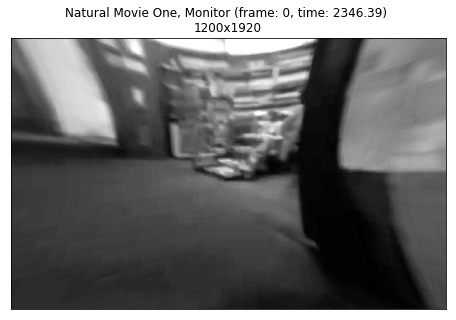

In [11]:
frame, timestamp = stim_table.iloc[0]['data'], stim_table.iloc[0]['timestamps']
image = natural_movie_one_stimulus.indexed_timeseries.data.value[int(frame),:,:]
m = si.BrainObservatoryMonitor()
fig, ax = plt.subplots(1,1, figsize=(10,5))
m.show_image(m.natural_movie_image_to_screen(image, origin='upper'), ax=ax,origin='upper', warp=True, show=False)
_ = ax.set_title('Natural Movie One, Monitor (frame: %i, time: %5.2f) \n1200x1920' % (frame, timestamp))

Now that we have explored what was shown to the animal, what can we find out about the data that was recorded?  Lets start off by gathering a summary of the metadata related to the imaging plane:

In [12]:
for two_photon_series in nwb_data.acquisition:
    print two_photon_series.description
    print two_photon_series.dimension.value
    print two_photon_series.field_of_view.value
    
    imaging_plane = two_photon_series.imaging_plane
    print imaging_plane.name
    print imaging_plane.location
    print imaging_plane.device
    print imaging_plane.imaging_rate
    print imaging_plane.indicator
    print imaging_plane.excitation_lambda
    print two_photon_series.bits_per_pixel
    
dimension = two_photon_series.dimension.value
field_of_view = two_photon_series.field_of_view.value

Unprocessed in-vivo two-photon calcium imaging of neuronal activity
[512 512]
[ 0.0004  0.0004]
imaging_plane_1
VISp
2-photon microscope
31Hz
GCaMP6f
910 nanometers
8


Next, lets see what processed data associated with this experiment is available.  Lets call up the `brain_observatory_pipeline` processing module:

In [13]:
pipeline = nwb_data.get_processing_module('brain_observatory_pipeline')
for container in pipeline.containers:
    print container.name

MotionCorrection
DfOverF
Fluorescence
BehavioralTimeSeries
ImageSegmentation
PupilTracking
EyeTracking


Each of these modules contain the result of some processing of raw data signals acquired during the session (For more information on the processing, check out the Brain Observatory <a http://help.brain-map.org/download/attachments/10616846/VisualCoding_Overview.pdf>whitepaper</a>). Now that we know the types of processed signals, lets start with some behavioral measurements from the experiment. We can look at the running speed of the animal (`BehavioralTimeSeries`), as well as information about pupil size and eye position obtained by processing a standard camera recording the gaze of the eye during the session:

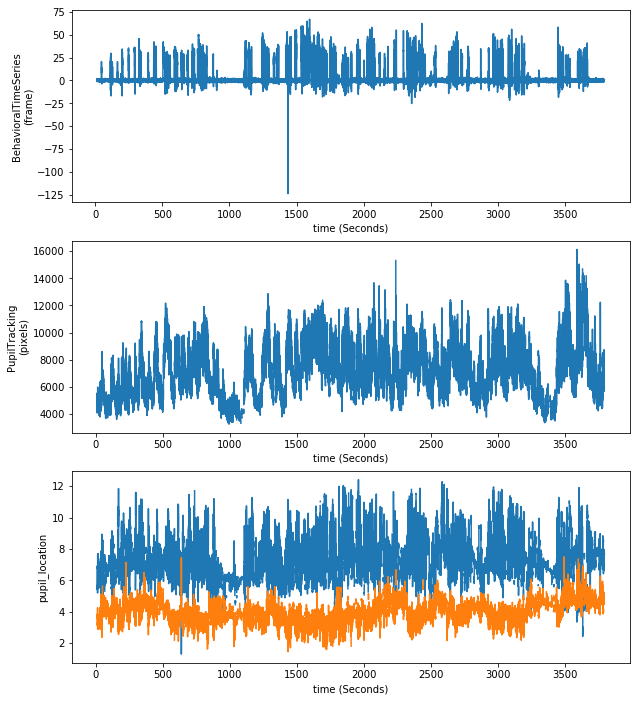

In [14]:
fig, axes = plt.subplots(3,1, figsize=(10,12))
for ii, container_name in enumerate(['BehavioralTimeSeries', 'PupilTracking']):
    ax = axes[ii]
    ds = pipeline.get_container(container_name)
    ts = ds.time_series
    data = ts.data.value
    timestamps = ts.timestamps.value


    ax.plot(timestamps, data)
    ax.set_xlabel('time (%s)' % ts.timestamps_unit)
    ax.set_ylabel('%s\n(%s)' % (ds.name, ts.unit))
    
ds = pipeline.get_container('EyeTracking')
for ss in ds.spatial_series:
    if ss.name == 'pupil_location':
    
        ax = axes[ii+1]
        data = ss.data.value
        timestamps = ss.timestamps.value


        ax.plot(timestamps, data, label='hi')
        ax.set_xlabel('time (%s)' % ss.timestamps_unit)
        ax.set_ylabel('%s' % (ss.name,))

Now lets look at the responses of some neurons in the imaging plaine. Lets plot a birds-eye view of the segmentation:

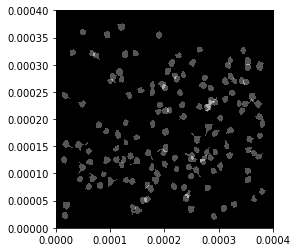

In [15]:
image_segmentation = pipeline.get_container('ImageSegmentation')
segmentation_mask = np.zeros(dimension)
extent = np.zeros(4)
extent[1] = field_of_view[0]
extent[3] = field_of_view[1]
for roi in image_segmentation.plane_segmentations[0].roi_list:
    segmentation_mask += roi.img_mask.value
_ = plt.imshow(segmentation_mask, cmap=plt.cm.gray, extent=extent)

Each of these segmented ROI's has a dF/F trace stored in the `DfOverF` processing module.  Lastly, we plot this data for each cell:

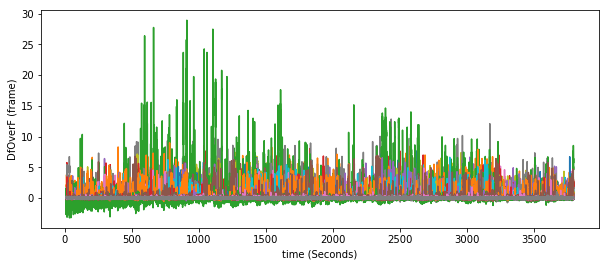

In [16]:
ds = pipeline.get_container('DfOverF')
ts = ds.roi_response_series[0]
timestamps = ts.timestamps.value
data = ts.data.value

fig, ax = plt.subplots(1,1, figsize=(10,4))
# plt.plot(timestamps, data.T)

ax.plot(timestamps, data.T)
ax.set_xlabel('time (%s)' % ts.timestamps_unit)
_ = ax.set_ylabel('%s (%s)' % (ds.name, ts.unit))